In [5]:
from sbibm import get_task
from sbi.analysis import pairplot
from rbi.utils.nets import IndependentGaussianNet
from rbi.loss.loss_fn import NLLLoss

from rbi.utils.datasets import get_datasets, get_reference_posterior_fn
from rbi.defenses.regularized_loss import GaussianNoiseJacobiRegularizer, WorstCaseJacobiRegularizer
from torch.distributions.kl import register_kl
import torch

import matplotlib.pyplot as plt

from typing import Union

In [6]:
train_loader, test_loader = get_datasets("gaussian_linear", N_train=1000, N_test=50000, batch_size=256)
analytic_post = get_reference_posterior_fn("gaussian_linear")

In [7]:
net1 = IndependentGaussianNet(10, 10, prediction_fn="mean")
loss_fn = NLLLoss(net1)

In [8]:
optim = torch.optim.Adam(net1.parameters())
for i in range(300):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%50)==0:
        print(loss.detach())

tensor(0.4630)
tensor(-0.0741)
tensor(-0.1281)
tensor(-0.1418)
tensor(-0.1408)
tensor(-0.1812)


In [14]:
net2 = IndependentGaussianNet(10,10, prediction_fn="mean")
loss_fn = NLLLoss(net2)
defense = GaussianNoiseJacobiRegularizer(net2, loss_fn, 0.2)
defense.activate()

In [15]:
optim = torch.optim.Adam(net2.parameters())
for i in range(300):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%50)==0:
        print(loss.detach())

tensor(0.4476)
tensor(0.1828)
tensor(0.1923)
tensor(0.2026)
tensor(0.1890)
tensor(0.2225)


In [11]:
net3 = IndependentGaussianNet(10,10, prediction_fn="mean")
loss_fn = NLLLoss(net3)
defense = WorstCaseJacobiRegularizer(net3, loss_fn, 0.2)
defense.activate()

In [12]:
optim = torch.optim.Adam(net3.parameters())
for i in range(300):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%50)==0:
        print(loss.detach())

tensor(0.4503)
tensor(0.0485)
tensor(0.0350)
tensor(0.0427)
tensor(0.0164)
tensor(0.0230)


In [16]:
from rbi.attacks.advertorch_attack import GradientAttack, L2PGDAttack
from rbi.metrics.empirical_metrics import EmpiricalLossMetric

In [17]:
attack = L2PGDAttack(net1, loss_fn._loss, eps=0.5)
metric = EmpiricalLossMetric(net1, attack, loss_fn)
clean_loss1 = metric.eval_clean(test_loader)
perturbed_loss1 = metric.eval_perturbed(test_loader)

attack = L2PGDAttack(net2, loss_fn._loss, eps=0.5)
metric = EmpiricalLossMetric(net2, attack, loss_fn)
clean_loss2 = metric.eval_clean(test_loader)
perturbed_loss2 = metric.eval_perturbed(test_loader)


attack = L2PGDAttack(net3, loss_fn._loss, eps=0.5)
metric = EmpiricalLossMetric(net3, attack, loss_fn)
clean_loss3 = metric.eval_clean(test_loader)
perturbed_loss3 = metric.eval_perturbed(test_loader)

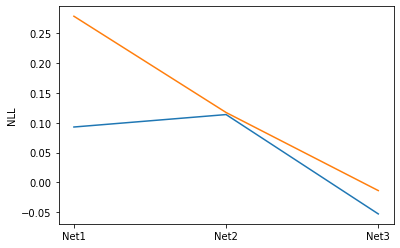

In [18]:
with torch.no_grad():
    plt.plot(["Net1", "Net2", "Net3"], [clean_loss1, clean_loss2, clean_loss3])
    plt.plot(["Net1", "Net2", "Net3"], [perturbed_loss1, perturbed_loss2, perturbed_loss3])
    plt.ylabel("NLL")

In [19]:
# Comput the approximation error
N = 10000
Xs = torch.randn(N, 10)

error1 = 0 
error2 = 0
error3 = 0

for x in Xs:
    ref_post = analytic_post(x)
    post1 = net1(x.unsqueeze(0))
    post1 = torch.distributions.MultivariateNormal(post1.loc, torch.diag_embed(post1.scale**2))
    post2 = net2(x.unsqueeze(0)) 
    post2= torch.distributions.MultivariateNormal(post2.loc, torch.diag_embed(post2.scale**2))
    post3 = net3(x.unsqueeze(0))
    post3 = torch.distributions.MultivariateNormal(post3.loc, torch.diag_embed(post3.scale**2))
    error1 += torch.distributions.kl_divergence(ref_post, post1)/N
    error2 += torch.distributions.kl_divergence(ref_post, post2)/N
    error3 += torch.distributions.kl_divergence(ref_post, post3)/N
    
    

c:\ProgramData\Miniconda3\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\ProgramData\Miniconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


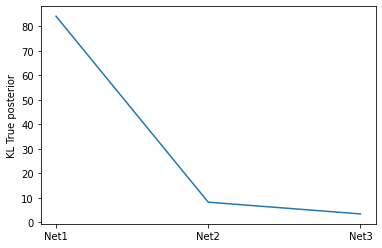

In [20]:
with torch.no_grad():
    plt.plot(["Net1", "Net2", "Net3"], [error1, error2, error3])
    plt.ylabel("KL True posterior")